# Final Project

Info 4609

Michael Murdock

## Vehicle Detection Classification on Images

I will be classifying images as vehicles or non-vehicles, using the vehicle image dataset from kaggle. First, I will load in the data in its original form, as well as its resized form for comparison. Next, I'll inspect images before and after resizing, to understand how the pixel adjustment affects the image and is computationally more efficient. After, I will split the original and resized data into training and testing sets in order to build decision trees for both forms of data. Before fitting the data to our model, I'll be reshaping it from its 4 dimensional representation to a 2 dimensional representation. This will provide compatability with Decision Trees and Random Forest Classifiers, as they both require a 2 dimensional input. Once the data is properly split and reshaped, I will train several decision trees using various test parameters to identify the best performing tree. The parameters which enable the best performing tree will be employed in the RFC at different estimators to combine trees and maximize accuracy. I'll then move on to the tensorflow implementation, where I read in the data directory using tensorflows built-in methods and associated modules for automatic preprocessing. Next, I'll build the sequential model, specifically a convolutional neural network with a layer for Conv2d to create a convolutional kernel, followed by a flatten layer to flatten multi-dimensional input into a single dimension, and finally 3 dense layers to reduce the dimensonality of the output until binary. I'll then fit both the preprocessed data and train datasets previously used in the decision tree and RFC, in order to compare and contrast results. Finally I'll evaluate both models through plotting accuracy and losses, as well the models predictions on a subset of images in the dataset. Here I will also take an image of my own car, read it in and process with cv2 (since plt.imread identifies the inherent extension) and classify the unseen image with both of my models. 

# Overview

- [Set Up](#Set-Up)
  - [Import Packages](#Import-Packages)
  - [Check Working Dir](#Check-Working-Dir)
  - [Colab Kaggle Data Import Steps](#Colab-Kaggle-Data-Import-Steps)
- [Import and Prepare Images](#Import-and-Prepare-Data)
  - [Load and Label Data](#Load-and-Label-Data)
  - [Read Images without Resizing](#Read-Images-without-Resizing)
  - [Read and Resize Images for Comparison](#Read-and-Resize-Images-for-Comparison)
  - [View Images Before and After Resizing](#View-Images-Before-and-After-Resizing)
- [Decision Tree and RFC Implementation](#Decision-Tree-and-RFC-Implementation)
  - [Split and Inspect](#Split-and-Inspect)
  - [Reshape from 4d to 2d](#Reshape-from-4d-to-2d)
  - [Instantiate and Train Decision Tree](#Instantiate-and-Train-Decision-Tree)
  - [Plot-Accuracies-and-Best-Performing-Tree](#Plot-Accuracies-and-Best-Performing-Tree)
  - [Instantiate and Train Random Forest](#Instantiate-and-Train-Random-Forest)
  - [Evaluate RFC](#Evaluate-RFC)
     - [Plot Train and Test Accuracies](#Plot-Train-and-Test-Accuracies)
     - [Plot Predictions with RFC](#Plot-Predictions-with-RFC)
     - [Classify My Car with RFC](#Classify-My-Car-with-RFC)
      
- [Tensorflow Implentation](#Tensorflow-Implentation)
  - [Generate Batches of Augmented Data with Tensorflow Methods](#Generate-Batches-of-Augmented-Data-with-Tensorflow-Methods)
  - [Build and Compile Sequential Model](#Build-and-Compile-Sequential-Model)
  - [Fit Model with Augmented Data](#Fit-Model-with-Augmented-Data)
  - [Fit Model with cv2 Preprocessed Data](#Fit-Model-with-cv2-Preprocessed-Data)
  - [Evaluate CNN](#Evaluate-CNN)
    - [Plot Predictions with CNN](#Plot-Predictions-with-CNN)
    - [Plot CNN Accuracy and Loss](#Plot-CNN-Accuracy-and-Loss)

# Set Up

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
from skimage.transform import resize

from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree


import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

Init Plugin
Init Graph Optimizer
Init Kernel


### Check Working Dir

In [2]:
os.getcwd()

'/Users/michaelm/Dropbox/INFO4604/Final Project'

### Colab Kaggle Data Download Steps

- Steps only required for importing data into Colabs content folder in Google Drive if tensorflow is not installed locally

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d brsdincer/vehicle-detection-image-set
! unzip vehicle-detection-image-set.zip

mkdir: /Users/michaelm/.kaggle: File exists
cp: kaggle.json: No such file or directory
zsh:1: command not found: kaggle
unzip:  cannot find or open vehicle-detection-image-set.zip, vehicle-detection-image-set.zip.zip or vehicle-detection-image-set.zip.ZIP.


# Import and Prepare Images

### Load and Label Data

In [4]:
labs, rel_paths, clabs = np.array([]), [], ''

# iterate through paths in data directory
for data in os.walk('data'):
    # If dir is not the data/ directory
    if data[0] != 'data':
        # Get dir name (vehicle or non-vehicle)
        clabs = data[0].split('/')[1]
    # iterate through files in dirs
    for file_ in data[2]:
        # append label to array
        labs = np.append(labs, np.where(clabs == 'vehicles', 1, 0)).astype(int)
        # append relative file path
        rel_paths.append(f'{data[0]}/{file_}')

# store in df and shuffle
df_shuffled = pd.DataFrame(
    {'paths': rel_paths, 'labels': labs}).sample(
        frac=1, random_state=123).reset_index()

df_shuffled.head()

,index,paths,labels
0,10079,data/vehicles/366.png,1
1,5914,data/non-vehicles/extra5005.png,0
2,10361,data/vehicles/right (219).png,1
3,15977,data/vehicles/43.png,1
4,5379,data/non-vehicles/extra3465.png,0


### Read Images without Resizing

In [5]:
labels = df_shuffled['labels']
images = np.array([cv2.imread(p) for p in df_shuffled['paths']])
print(f'Images: \nshape - {images.shape}, size - {images.size}')

Images: 
shape - (17760, 64, 64, 3), size - 218234880


### Read and Resize Images for Comparison

In [6]:
resized_images = np.array([cv2.resize(cv2.imread(p), (64, 64))
                          for p in df_shuffled['paths']])

# Reading in with plt seems slightly slower
# resize = np.array([resize(plt.imread(p), (32,32,3)) for p in df_shuffled['paths']])

### View Images Before and After Resizing

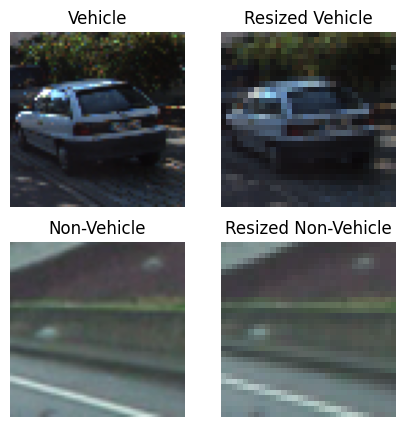

In [7]:
def label(df, r):
    return np.where(df['labels'][r] == 1, 'Vehicle', 'Non-Vehicle')


def read_resize_plot(df, r, r2):
    # set fig
    f, (ax, ax1) = plt.subplots(2, 2, figsize=(5, 5))

    rlab, rlab2 = label(df, r), label(df, r2)

    ax[0].imshow(plt.imread(df['paths'][r]))
    ax[1].imshow(np.array(resize(plt.imread(df['paths'][r]), (32, 32, 3))))
    ax[0].set_title(rlab), ax[1].set_title(f'Resized {rlab}')
    ax[0].set_axis_off(), ax[1].set_axis_off()

    ax1[0].imshow(plt.imread(df['paths'][r2]))
    ax1[1].imshow(np.array(resize(plt.imread(df['paths'][r2]), (32, 32, 3))))
    ax1[0].set_title(rlab2), ax1[1].set_title(f'Resized {rlab2}')
    ax1[0].set_axis_off(), ax1[1].set_axis_off()


read_resize_plot(df_shuffled, 15, 25)

# Decision Tree and RFC Implementation


- Will be testing different accuracies for decision trees at various depth and sample leafs. 
- Best decision tree performance will be employed in the Random Forest Classifier and tested at various estimators
- Accuracy and loss will be compared between the RFC model and CNN

### Split and Inspect

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.25)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13320, 64, 64, 3), (4440, 64, 64, 3), (13320,), (4440,))

### Reshape from 4d to 2d

In [9]:
# Reshaping for compatability with decision tree
nsamples, nx, ny, nz = X_train.shape
d2_Xtrain = X_train.reshape((nsamples, nx*ny*nz))

nsamples_, nx_, ny_, nz_ = X_test.shape
d2_Xtest = X_test.reshape((nsamples_, nx_*ny_*nz_))

d2_Xtrain.shape, d2_Xtest.shape

((13320, 12288), (4440, 12288))

### Instantiate and Train Decision Tree

- This cell takes a while to run. The RFC below employs the best parameters, so cell is not necessary to run.

In [10]:
max_depths = [3, 8, 14, 100]
min_leafs = [1, 5, 10, 15, 50]


training = []
testing = []
depths = []
leafs = []


for m in max_depths:
    for j in min_leafs:

        model = DecisionTreeClassifier(
            criterion='gini', max_depth=m, min_samples_leaf=j, random_state=123)
        model.fit(d2_Xtrain, y_train)

        test_predictions = model.predict(d2_Xtest)
        train_predictions = model.predict(d2_Xtrain)

        training.append(accuracy_score(train_predictions, y_train))
        testing.append(accuracy_score(test_predictions, y_test))
        depths.append(m)
        leafs.append(j)

        print(f'Model trained at {m} depths and {j} leafs')


df_ = pd.DataFrame({'train_acc': training, 'test_acc': testing,
                    'max_depth': depths, 'min_samples': leafs})
display(df_)

df_.loc[df_.test_acc.idxmax()]

Model trained at 3 depths and 1 leafs
Model trained at 3 depths and 5 leafs
Model trained at 3 depths and 10 leafs
Model trained at 3 depths and 15 leafs
Model trained at 3 depths and 50 leafs
Model trained at 8 depths and 1 leafs
Model trained at 8 depths and 5 leafs
Model trained at 8 depths and 10 leafs
Model trained at 8 depths and 15 leafs
Model trained at 8 depths and 50 leafs
Model trained at 14 depths and 1 leafs
Model trained at 14 depths and 5 leafs
Model trained at 14 depths and 10 leafs
Model trained at 14 depths and 15 leafs
Model trained at 14 depths and 50 leafs
Model trained at 100 depths and 1 leafs
Model trained at 100 depths and 5 leafs
Model trained at 100 depths and 10 leafs
Model trained at 100 depths and 15 leafs
Model trained at 100 depths and 50 leafs


,train_acc,test_acc,max_depth,min_samples
0,0.840766,0.843468,3,1
1,0.840766,0.843468,3,5
2,0.840766,0.843468,3,10
3,0.840766,0.843468,3,15
4,0.840766,0.843468,3,50
5,0.952703,0.913063,8,1
6,0.949399,0.911937,8,5
7,0.944369,0.911486,8,10
8,0.940691,0.911486,8,15
9,0.922898,0.892793,8,50


train_acc       0.988213
test_acc        0.925901
max_depth      14.000000
min_samples     1.000000
Name: 10, dtype: float64

### Plot Accuracies and Best Performing Tree

Text(0, 0.5, 'Test Accuracy')

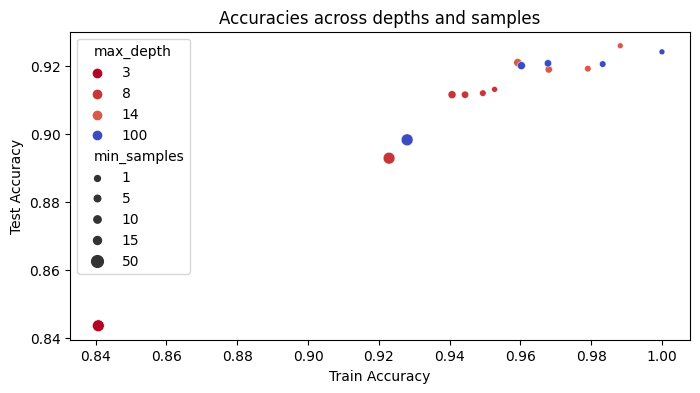

In [11]:
import seaborn as sb

f, ax = plt.subplots(figsize=(8, 4))

sb.scatterplot(data=df_, x='train_acc', y='test_acc',
               hue='max_depth', size='min_samples', palette='coolwarm_r')

plt.title('Accuracies across depths and samples')
plt.xlabel('Train Accuracy')
plt.ylabel('Test Accuracy')

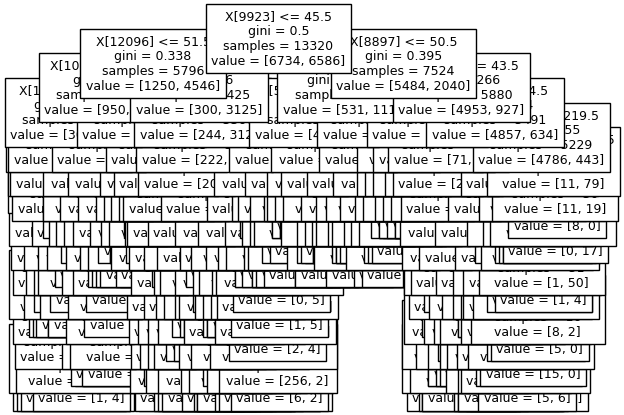

In [12]:
plt.figure()

best_model = DecisionTreeClassifier(
    criterion='gini', max_depth=14, min_samples_leaf=5, random_state=123).fit(
    d2_Xtrain, y_train)

tree.plot_tree(best_model, fontsize=9)

plt.show()

### Instantiate and Train Random Forest

In [13]:
# print(df_.loc[df_['test_acc'].idxmax()])

estimators = [10, 50, 100, 300]
training = []
testing = []
n_est = []

for e in estimators:

    forest_model = RandomForestClassifier(
        n_estimators=e, max_depth=14, min_samples_leaf=5, random_state=123)
    forest_model.fit(d2_Xtrain, y_train)

    test_predictions = forest_model.predict(d2_Xtest)
    train_predictions = forest_model.predict(d2_Xtrain)

    training.append(accuracy_score(train_predictions, y_train))
    testing.append(accuracy_score(test_predictions, y_test))
    n_est.append(e)
    
    print(f'Model trained at {e} estimators')

forest_df = pd.DataFrame(
    {'train_acc': training, 'test_acc': testing, 'n_estimator': n_est})

display(forest_df)

forest_df.loc[forest_df.test_acc.idxmax()]

Model trained at 10 estimators
Model trained at 50 estimators
Model trained at 100 estimators
Model trained at 300 estimators


,train_acc,test_acc,n_estimator
0,0.984009,0.955631,10
1,0.988664,0.961712,50
2,0.988363,0.963063,100
3,0.989039,0.962387,300


train_acc        0.988363
test_acc         0.963063
n_estimator    100.000000
Name: 2, dtype: float64

## Evaluate RFC

### Plot Train and Test Accuracies

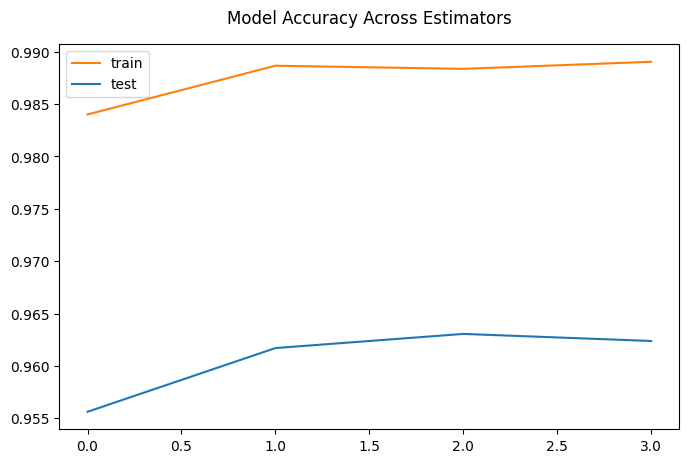

In [14]:
f, ax = plt.subplots(figsize=(8,5))

ax.plot(forest_df['train_acc'], label='train', c='tab:orange')
ax.plot(forest_df['test_acc'], label='test', c='tab:blue')

ax.set_title('Model Accuracy Across Estimators', pad=15)
ax.legend()

### Plot Predictions with RFC

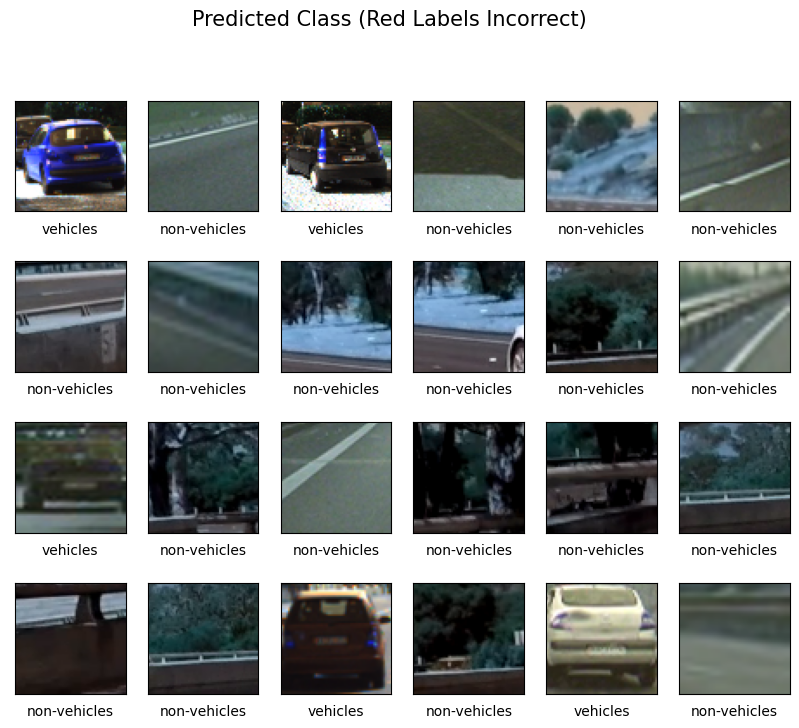

In [15]:
label_dict = {1.: 'vehicles', 0.: 'non-vehicles'}
y_fit = forest_model.predict(d2_Xtest)


def plot_predictions(xtest, ytest, yfit, samplesr, samplesc):
    fig, ax = plt.subplots(samplesr, samplesc, figsize=(10, 8))
    pred_sub = np.array(ytest)
    for i, axi in enumerate(ax.flat):
        axi.imshow(xtest[i], cmap='bone')
        axi.set(xticks=[], yticks=[])
        axi.set_xlabel(label_dict[yfit[i]],
                       color='black' if yfit[i] == pred_sub[i] else 'red')
    fig.suptitle('Predicted Class (Red Labels Incorrect)', size=15)


plot_predictions(X_test, y_test, y_fit, 4, 6)

### Classify My Car with RFC

Predicted: Vehicle


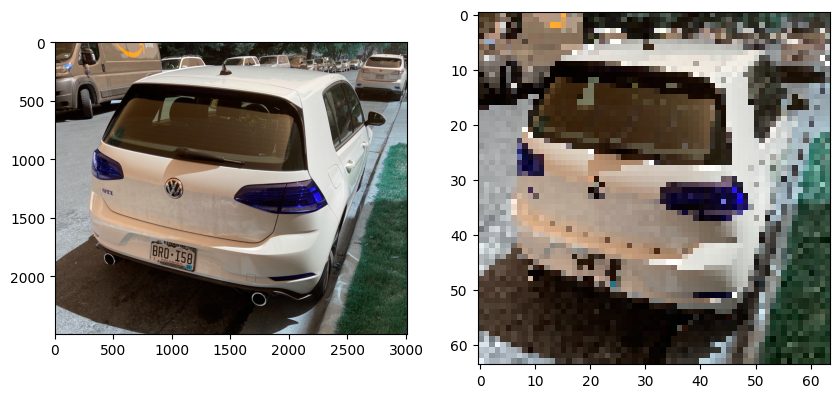

In [16]:
def process_iphone_photo(png):
    '''
    Resize, reshape, and plot Iphone images for inspecting and compatability 
    with decision tree model.

    '''
    # Set axis
    f, ax = plt.subplots(1, 2, figsize=(10, 6))

    # Resize
    car_image = cv2.resize(cv2.imread(png), (64, 64))

    # Plot image before and after resizing
    ax[0].imshow(cv2.imread(png))
    ax[1].imshow(car_image)

    # Reshape
    nx, ny, nz = car_image.shape
    shaped_image = car_image.reshape(1, nx*ny*nz)

    return shaped_image


# Process and Classify my Image
my_car = process_iphone_photo('my_car.png')

print('Predicted:', np.where(forest_model.predict(
    my_car), 'Vehicle', 'Non-Vehicle')[0])

# Tensorflow Implentation


Using a convolutional neural network to classify images. Starting with Conv2d layer which performs elementwise multiplication, resulting in a single output pixel. Specifying our input shape as 64 by 64 with a channel of 3 for RGB, and the shape of the convolutional kernel as 3 by 3 with a total of 32 layers.

### Generate Batches of Augmented Data with Tensorflow Methods

In [46]:
# will test both preprocessed and original data

data_gen = ImageDataGenerator(rescale=1/255, validation_split=.25)

t_gen = data_gen.flow_from_directory(
    'data',
    class_mode='binary',
    shuffle=True,
    target_size=(64, 64),
    batch_size=64
)

validator_gen = data_gen.flow_from_directory(
    'data',
    class_mode='binary',
    shuffle=True,
    target_size=(64, 64),
    batch_size=64,
    subset='validation'
)

Found 17760 images belonging to 2 classes.
Found 4440 images belonging to 2 classes.


### Build and Compile Sequential Model

In [47]:
def build_sequential():

    keras_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), input_shape=(
            64, 64, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # compiling model with adam optimizer and binary crossentropy loss function
    keras_model.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

    return keras_model


keras_model = build_sequential()
keras_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
flatten_6 (Flatten)          (None, 123008)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                7872576   
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 7,875,585
Trainable params: 7,875,585
Non-trainable params: 0
_________________________________________________________________


### Fit Model with Augmented Data

In [44]:
augmented_hist = keras_model.fit(
    t_gen, epochs=20, steps_per_epoch=np.ceil(17746/64), 
    validation_data=validator_gen, validation_steps=4440/64, verbose=1)

# avgs 8s per epoch

Epoch 1/20


2022-11-13 22:33:37.807570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


270/270 [==============================] - ETA: 0s - loss: 0.2015 - accuracy: 0.9257

2022-11-13 22:33:52.014277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


270/270 [==============================] - 17s 63ms/step - loss: 0.2015 - accuracy: 0.9257 - val_loss: 0.1169 - val_accuracy: 0.9563
Epoch 2/20
270/270 [==============================] - 17s 62ms/step - loss: 0.0696 - accuracy: 0.9768 - val_loss: 0.0244 - val_accuracy: 0.9944
Epoch 3/20
270/270 [==============================] - 17s 62ms/step - loss: 0.0406 - accuracy: 0.9872 - val_loss: 0.0182 - val_accuracy: 0.9946
Epoch 4/20
270/270 [==============================] - 17s 62ms/step - loss: 0.0239 - accuracy: 0.9923 - val_loss: 0.0175 - val_accuracy: 0.9946
Epoch 5/20
270/270 [==============================] - 17s 62ms/step - loss: 0.0169 - accuracy: 0.9947 - val_loss: 0.0204 - val_accuracy: 0.9930
Epoch 6/20
270/270 [==============================] - 17s 61ms/step - loss: 0.0113 - accuracy: 0.9965 - val_loss: 0.0036 - val_accuracy: 0.9995
Epoch 7/20
270/270 [==============================] - 17s 62ms/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.0023 - val_accuracy: 0.9995
Epo

### Fit Model with CV2 Preprocessed Data

In [49]:
# Instantiate new model for non-preprocessed data
keras_model2 = build_sequential()

# Keras models have nice validation_split paramter 
# (i.e., don't need to use scikit train_test_split)
standard_hist = keras_model2.fit(
    resized_images, labels, epochs=20, validation_split=.25,
    steps_per_epoch=np.ceil(17746/64), verbose=1)

# avgs 15s per epoch

Epoch 1/20


2022-11-13 22:52:26.033891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


278/278 [==============================] - ETA: 0s - loss: 18.3937 - accuracy: 0.9049

2022-11-13 22:52:40.339906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


278/278 [==============================] - 20s 72ms/step - loss: 18.3937 - accuracy: 0.9049 - val_loss: 0.3805 - val_accuracy: 0.9624
Epoch 2/20
278/278 [==============================] - 20s 73ms/step - loss: 0.2264 - accuracy: 0.9616 - val_loss: 0.3091 - val_accuracy: 0.9631
Epoch 3/20
278/278 [==============================] - 20s 72ms/step - loss: 0.0620 - accuracy: 0.9844 - val_loss: 0.3288 - val_accuracy: 0.9579
Epoch 4/20
278/278 [==============================] - 20s 72ms/step - loss: 0.0612 - accuracy: 0.9855 - val_loss: 0.2761 - val_accuracy: 0.9721
Epoch 5/20
278/278 [==============================] - 20s 73ms/step - loss: 0.0352 - accuracy: 0.9910 - val_loss: 0.3059 - val_accuracy: 0.9685
Epoch 6/20
278/278 [==============================] - 20s 72ms/step - loss: 0.0461 - accuracy: 0.9895 - val_loss: 0.3601 - val_accuracy: 0.9718
Epoch 7/20
278/278 [==============================] - 20s 72ms/step - loss: 0.0864 - accuracy: 0.9823 - val_loss: 0.3660 - val_accuracy: 0.9660
Ep

# Evaluate CNN

## Augmented Data

### Plot Predictions with CNN

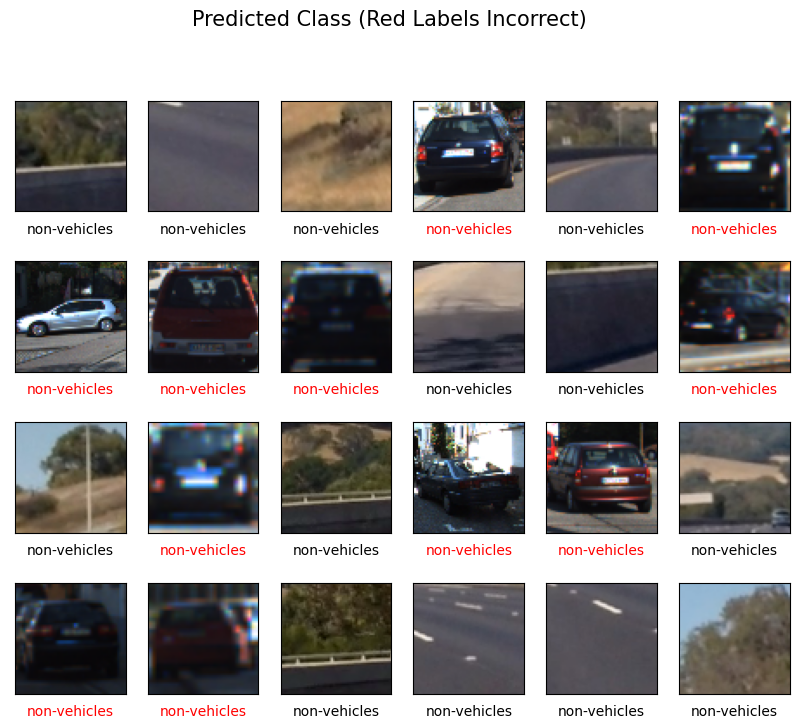

In [59]:
# get x_test and y_test
xt, yt = next(validator_gen)

# Predict with CNN
y_fit_tgen = keras_model.predict(xt)

# Convert value to int for classifying
yf = [int(i) for i in y_fit_tgen]

# Plot predictions
rd = np.random.choice(len(xt))
plot_predictions(xt[rd:rd+24], yt[rd:rd+24], yf, 4, 6)

### Plot Accuracy and Loss

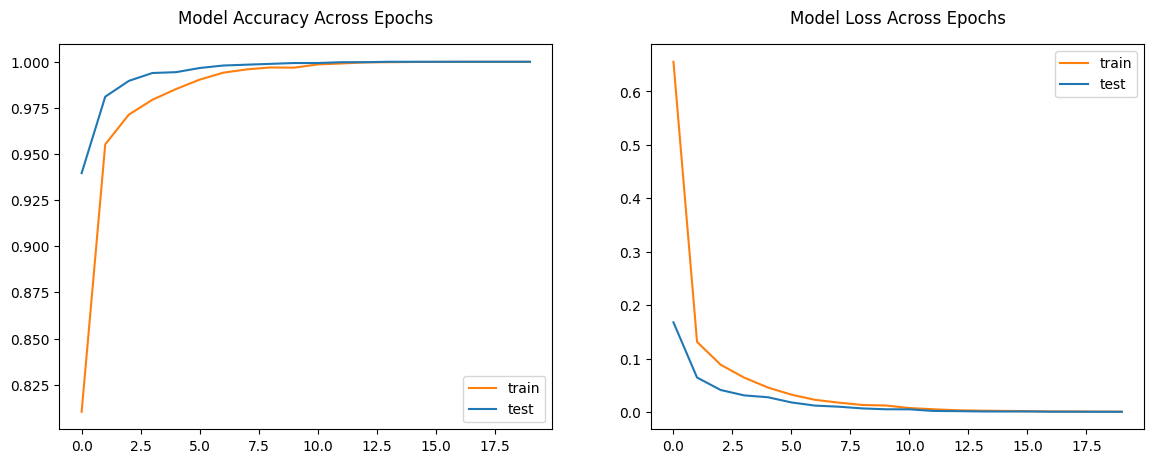

In [35]:
def plot_accuracy_loss(model_history):
    f, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(model_history.history['accuracy'],
               label='train', c='tab:orange')
    ax[1].plot(model_history.history['loss'], label='train', c='tab:orange')

    try:
        if model_history.history['val_accuracy']:
            ax[0].plot(model_history.history['val_accuracy'],
                       label='test', c='tab:blue')
            ax[1].plot(model_history.history['val_loss'],
                       label='test', c='tab:blue')
    except KeyError:
        pass

    ax[0].legend()
    ax[0].set_title('Model Accuracy Across Epochs', pad=15)
    ax[1].legend()
    ax[1].set_title('Model Loss Across Epochs', pad=15)


plot_accuracy_loss(augmented_hist)

## CV2 Preprocessed Data

###  Plot Predictions

2022-11-13 23:39:01.908702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/var/folders/7z/lks_pjcd1fv91v27m8gf5l1h0000gn/T/ipykernel_81126/135450886.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plot_predictions(X_test[rd:rd+24], y_test[rd:rd+24], yf, 4, 6)


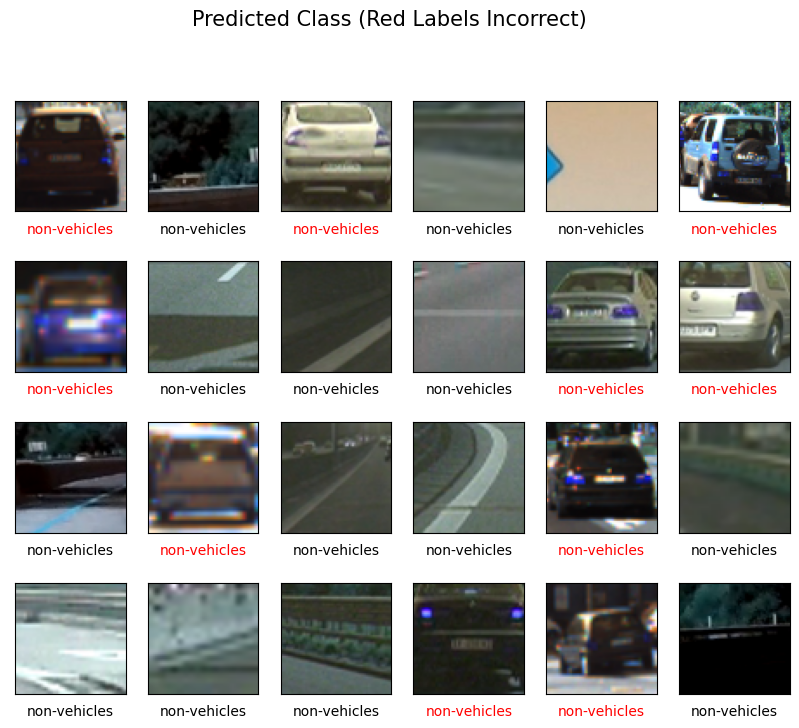

In [60]:
# Predict with CNN
y_fit_cv2 = keras_model2.predict(X_test)

# Convert value to int for classifying
yf_ = [int(i) for i in y_fit_cv2]

# Plot predictions
plot_predictions(X_test[rd:rd+24], y_test[rd:rd+24], yf, 4, 6)

### Plot Accuracy and Loss

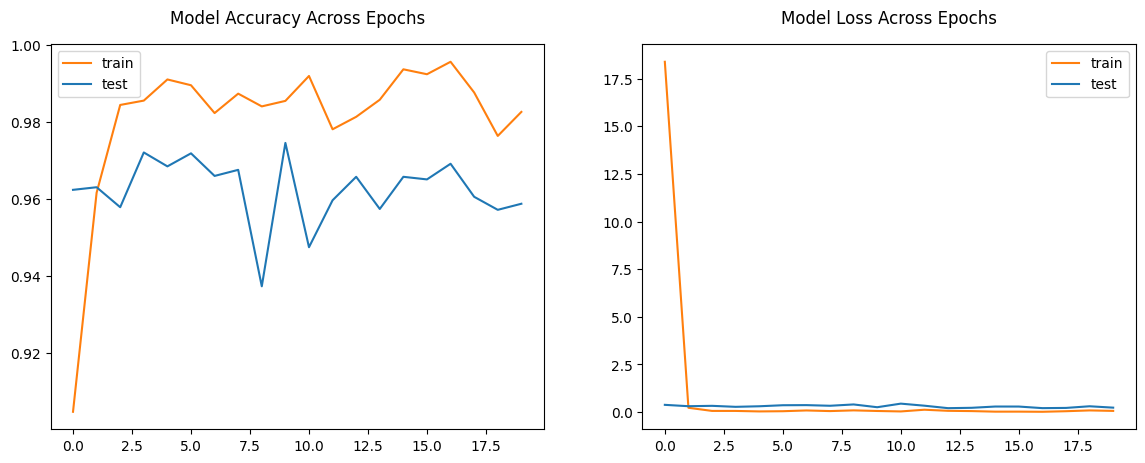

In [54]:
plot_accuracy_loss(standard_hist)

In [57]:
vw = cv2.resize(cv2.imread('my_car.png'), (64, 64))

n, r, z = vw.shape

np.where(keras_model.predict(vw.reshape(1, n, r, z)) >= 1,
         'Vehicle', 'Non-Vehicle')[0][0]


# Keras model also predicts my vehicle correctly

'Non-Vehicle'